In [20]:
#From https://github.com/PacktPublishing/Causal-Inference-and-Discovery-in-Python/blob/main/Chapter_13.ipynb

import os
os.environ['CASTLE_BACKEND'] = 'pytorch'

from collections import OrderedDict
import warnings

import numpy as np
import networkx as nx

from scipy import linalg 

from sklearn.linear_model import LinearRegression

import castle
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import DAG, IIDSimulation 

from castle.algorithms import PC, GES
from castle.algorithms import ANMNonlinear, ICALiNGAM, DirectLiNGAM
from castle.algorithms import Notears, NotearsNonlinear, GOLEM

from castle.common.priori_knowledge import PrioriKnowledge

from castle.common.independence_tests import hsic_test

import matplotlib.pyplot as plt

from dowhy import gcm
import pandas as pd

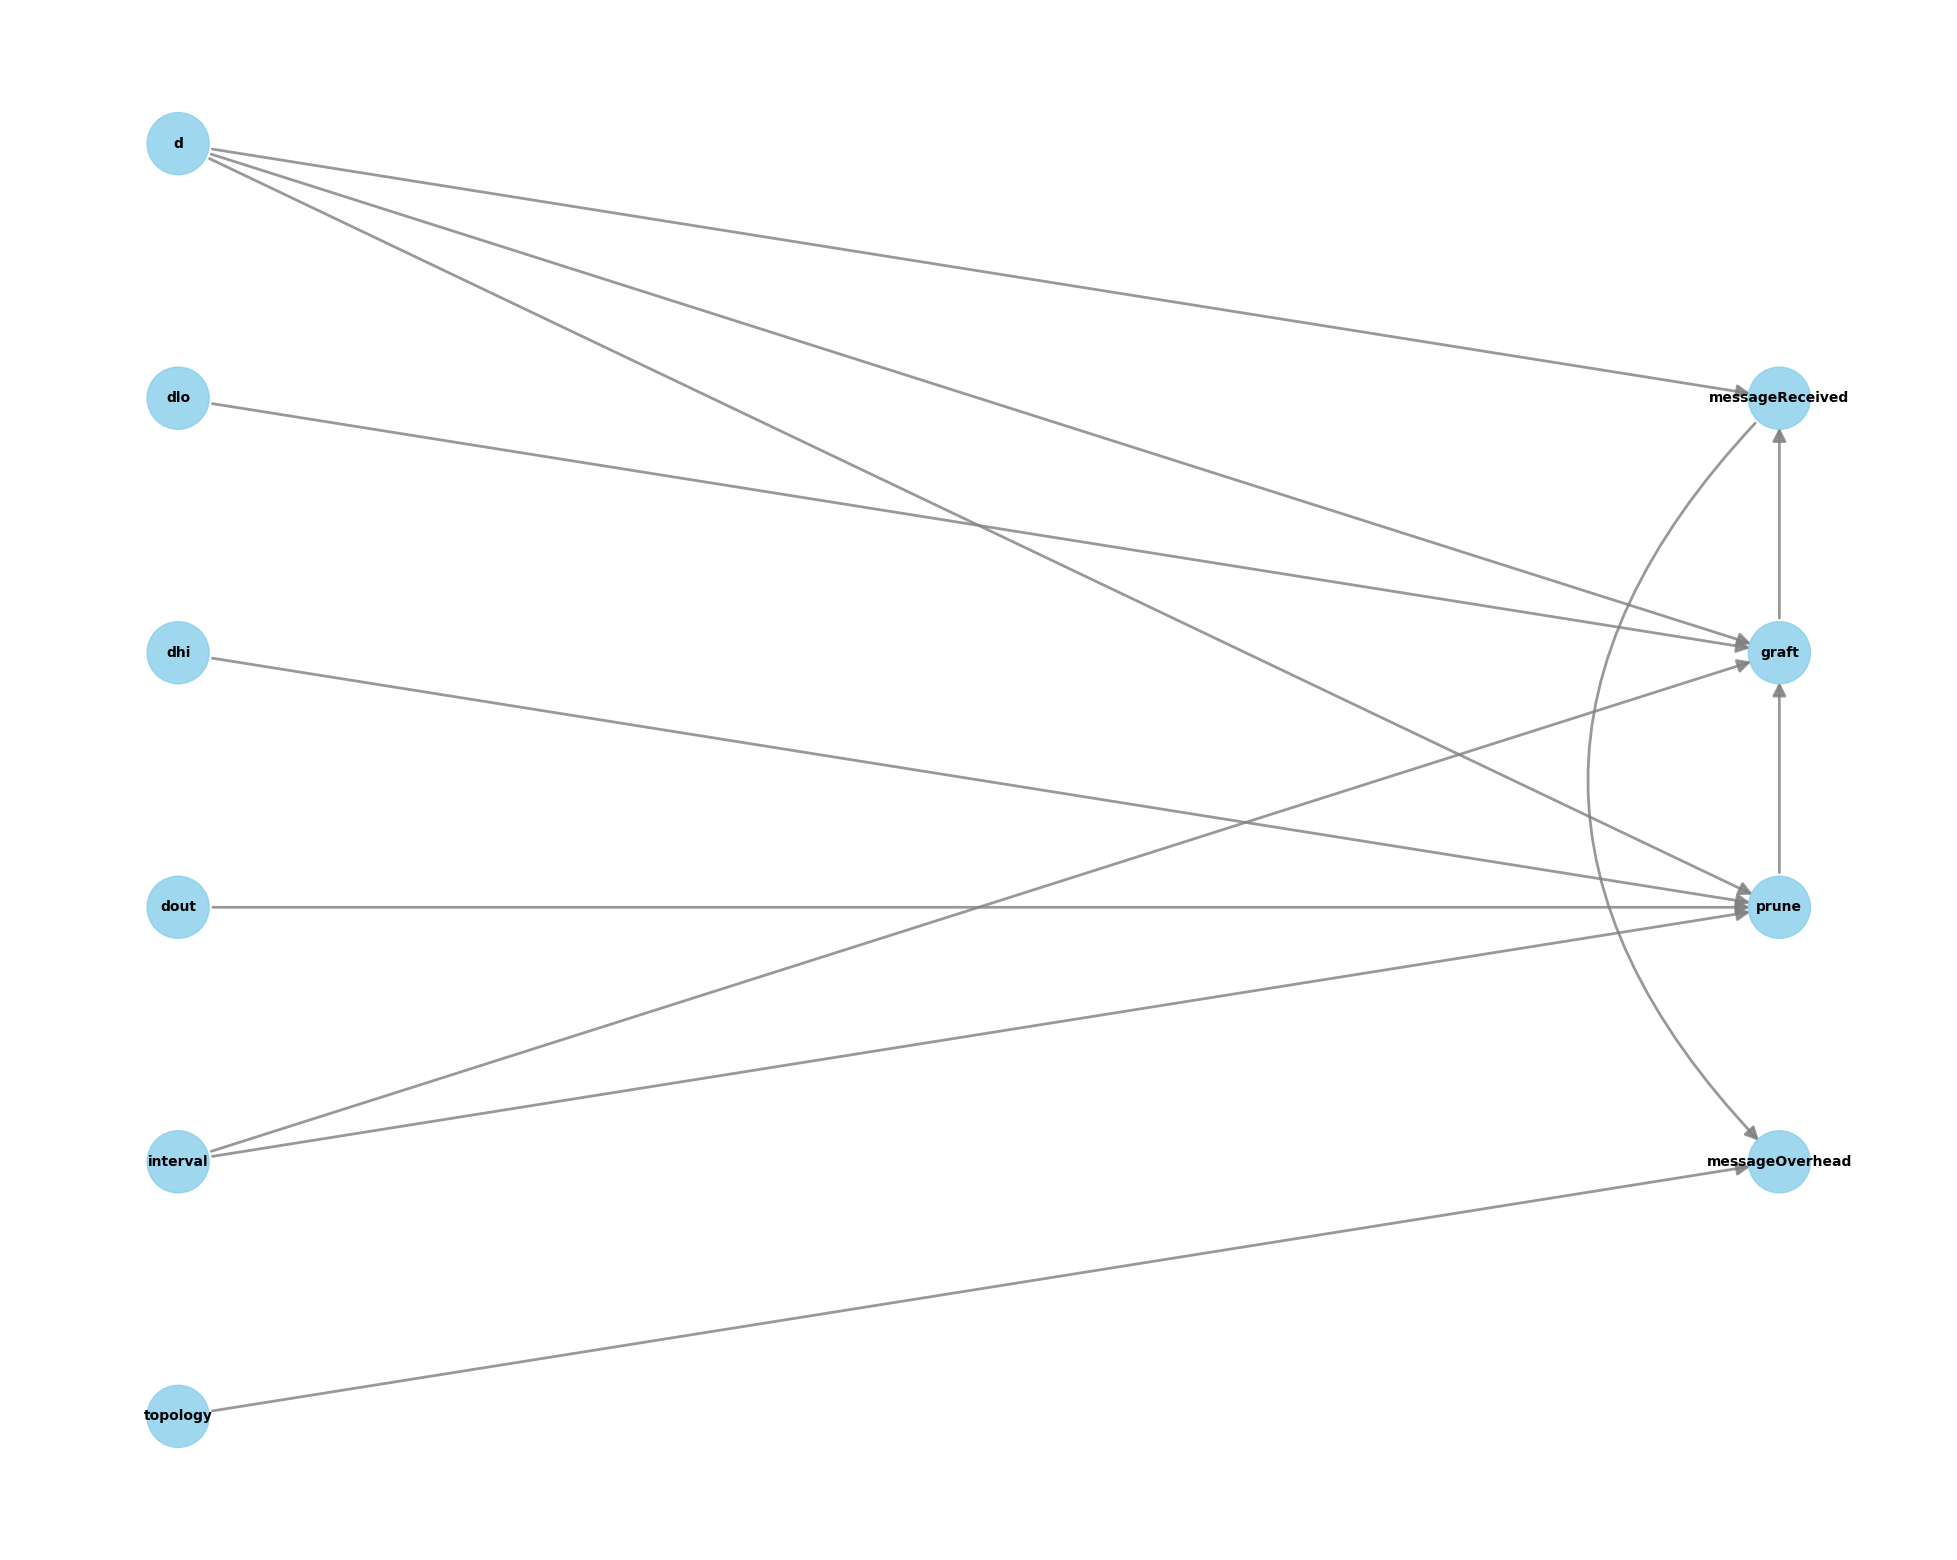

In [21]:
#Causal graph
causal_graph = nx.DiGraph([('d', 'messageReceived'),
                           ('d', 'graft'),
                           ('d', 'prune'),
                           ('dlo', 'graft'),
                           ('dhi', 'prune'),
                           ('dout', 'prune'),
                           ('interval', 'graft'),
                           ('interval', 'prune'),
                           ('prune', 'graft'),
                           ('messageReceived', 'messageOverhead'),
                           ('graft','messageReceived'),
                           ('topology', 'messageOverhead')
                         ])


G=gcm.util.plot(causal_graph, figure_size=[25, 20])
# nx.write_adjlist(H, "pc.adjlist")

In [22]:
#From digraph to adjancency matrix

# true_causal_matrix = nx.adjacency_matrix(causal_graph)
true_causal_matrix = nx.to_numpy_array(causal_graph)

print(true_causal_matrix)
print(causal_graph.nodes)

[[0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
['d', 'messageReceived', 'graft', 'prune', 'dlo', 'dhi', 'dout', 'interval', 'messageOverhead', 'topology']


In [33]:
#Treat dataset

#Import data 
# data = pd.read_csv('../datasets/consolidated.csv',header=0, index_col=0)
data = pd.read_csv('../../Datasets/consolidated5s_lotus.csv',header=0, index_col=0)
consolidated = pd.DataFrame(data)

consolidated = consolidated.drop(columns=['experiment'])#, 'messageBandwidth'])#, 'gossipBandwidth'])#, 'messageDuplicated'])#, 'n_nodes', 'consensus', 'messageDuplicated'])
consolidated = consolidated.rename(columns={'topology':'top'})#, 'totalBandwidth':'bandwidth', 'gossipBandwidth':'rpcs'})
consolidated['topology'] = 0
consolidated.loc[consolidated['top'] == 'general', 'topology'] = 1
consolidated = consolidated.loc[consolidated['totalBandwidth'] > 0]
consolidated = consolidated.drop(columns=['top'])
# consolidated.head(100)

consolidateddiff = consolidated.dropna()#.diff().dropna()

X = consolidateddiff[['d', 'messageReceived', 'graft', 'prune', 'dlo', 'dhi', 'dout', 'interval', 'messageOverhead', 'topology']].to_numpy()
consolidated = consolidateddiff[['d', 'messageReceived', 'graft', 'prune', 'dlo', 'dhi', 'dout', 'interval', 'messageOverhead', 'topology']]

#Rearrange columns according to nodes list
# nodes = causal_graph.nodes

# X = consolidated[['d', 'messageReceived', 'graft', 'prune', 'iwant', 'dlo', 'dhi', 'dscore', 'dlazy', 'ihave', 'dout', 'gossipFactor', 'interval', 'messageOverhead']].to_numpy()

# X = consolidated.to_numpy()
# print(X)
consolidated.head(500)

,d,messageReceived,graft,prune,dlo,dhi,dout,interval,messageOverhead,topology
0,8,56.0,0.0,0.0,6,12,2,1.0,345.0,0
1,8,73.0,0.0,0.0,6,12,2,1.0,466.0,0
2,8,124.0,0.0,0.0,6,12,2,1.0,781.0,0
3,8,111.0,0.0,0.0,6,12,2,1.0,734.0,0
4,8,91.0,0.0,0.0,6,12,2,1.0,554.0,0
...,...,...,...,...,...,...,...,...,...,...
495,8,61.0,0.0,0.0,6,12,2,3.0,665.0,0
496,8,122.0,0.0,0.0,6,12,2,3.0,1295.0,0
497,8,105.0,0.0,0.0,6,12,2,3.0,1184.0,0
498,8,139.0,0.0,0.0,6,12,2,3.0,1525.0,0


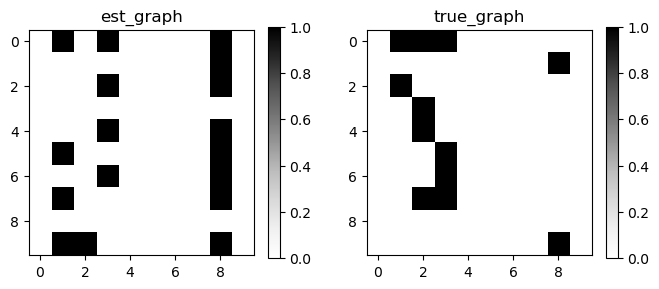

{'fdr': 0.7059, 'tpr': 0.4167, 'fpr': 0.3636, 'shd': 18, 'nnz': 17, 'precision': 0.2941, 'recall': 0.4167, 'F1': 0.3448, 'gscore': 0.0}


In [34]:
# structure learning
priori = PrioriKnowledge(X.shape[1])
priori.add_forbidden_edges([
(0,0),	(0,4),	(0,5),	(0,6),	(0,7),	(0,9),
(1,0),	(1,4),	(1,5),	(1,6),	(1,7),	(1,9),
(2,0),	(2,4),	(2,5),	(2,6),	(3,7),	(2,9),
(3,0),	(3,4),	(3,5),	(3,6),	(3,7),	(3,9),
(4,0),	(4,4),	(4,5),	(4,6),	(4,7),	(4,9),
(5,0),	(5,4),	(5,5),	(5,6),	(5,7),	(5,9),
(6,0),	(6,4),	(6,5),	(6,6),	(6,7),	(6,9),
(7,0),	(7,4),	(7,5),	(7,6),	(7,7),	(7,9),
(8,0),	(8,4),	(8,5),	(8,6),	(8,7),	(8,9),
(9,0),	(9,4),	(9,5),	(9,6),	(9,7),	(9,9),
])

priori.add_required_edges([(0, 1), (1,8)]) 
                           # (18, 16),
                           # (6,2),
                           # (5,3)])
pc = PC(variant='original', priori_knowledge=priori)
pc.learn(X)

# plot predict_dag and true_dag
GraphDAG(pc.causal_matrix, true_causal_matrix, 'result')

# calculate metrics
mt = MetricsDAG(pc.causal_matrix, true_causal_matrix)
print(mt.metrics)

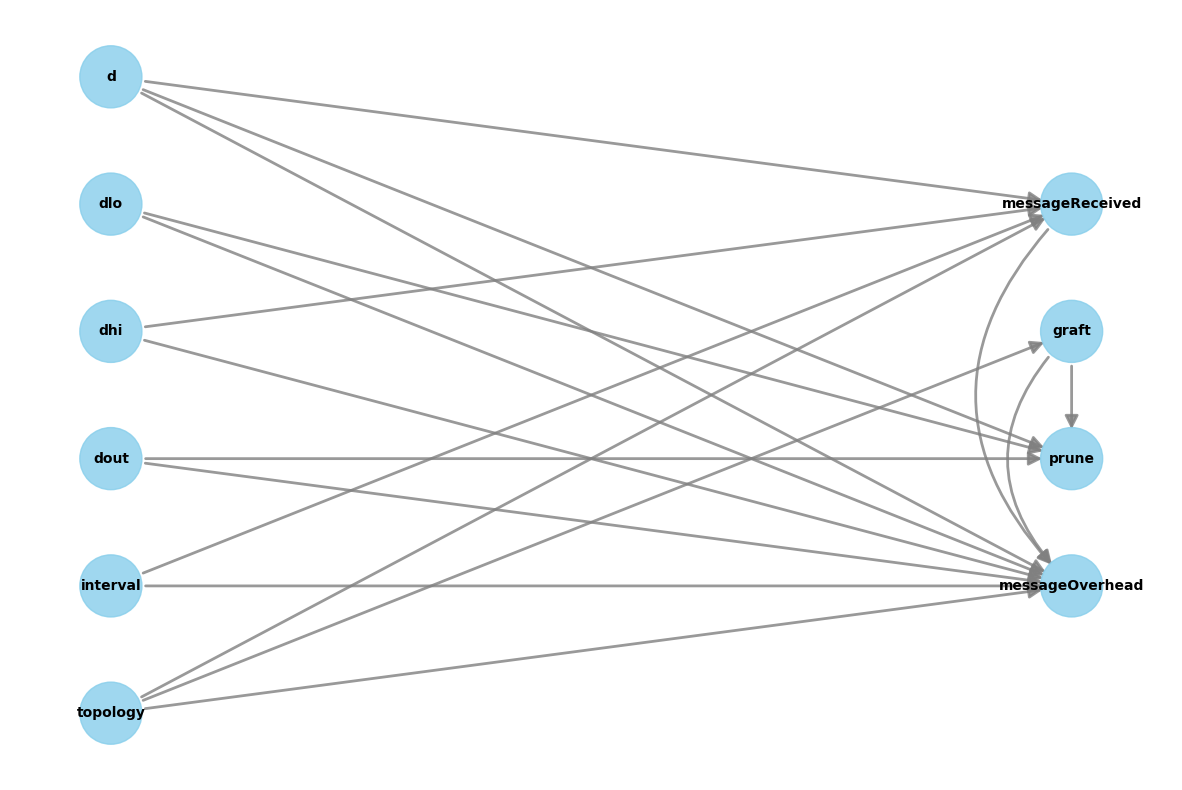

In [35]:
learned_causal_graph = nx.from_numpy_array(pc.causal_matrix, create_using=nx.DiGraph)

mapping = {0:'d',
            1:'messageReceived',
            2:'graft',
            3:'prune',
            4:'dlo',
            5:'dhi',
            6:'dout',
            7:'interval',
            8:'messageOverhead',
            9:'topology'}

# nx.set_node_attributes(learned_causal_graph, labels, "name")
H = nx.relabel_nodes(learned_causal_graph, mapping)

# fig, ax = plt.subplots(figsize=(30,30))

G=gcm.util.plot(H, figure_size=[15, 10])

nx.write_adjlist(H, "pc5s_lotus.adjlist")

# nx.draw(G)

# plt.savefig("PCNoPrioriKnowledge.png") # save as png
# plt.show() # displab

In [36]:
# Instantiate GES
ges = GES(criterion='bic')

# Train
ges.learn(X)

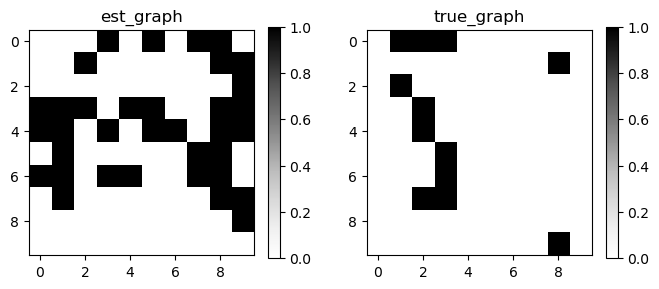

In [37]:
# Visualize
GraphDAG(
    est_dag=ges.causal_matrix, 
    true_dag=true_causal_matrix)

plt.show()

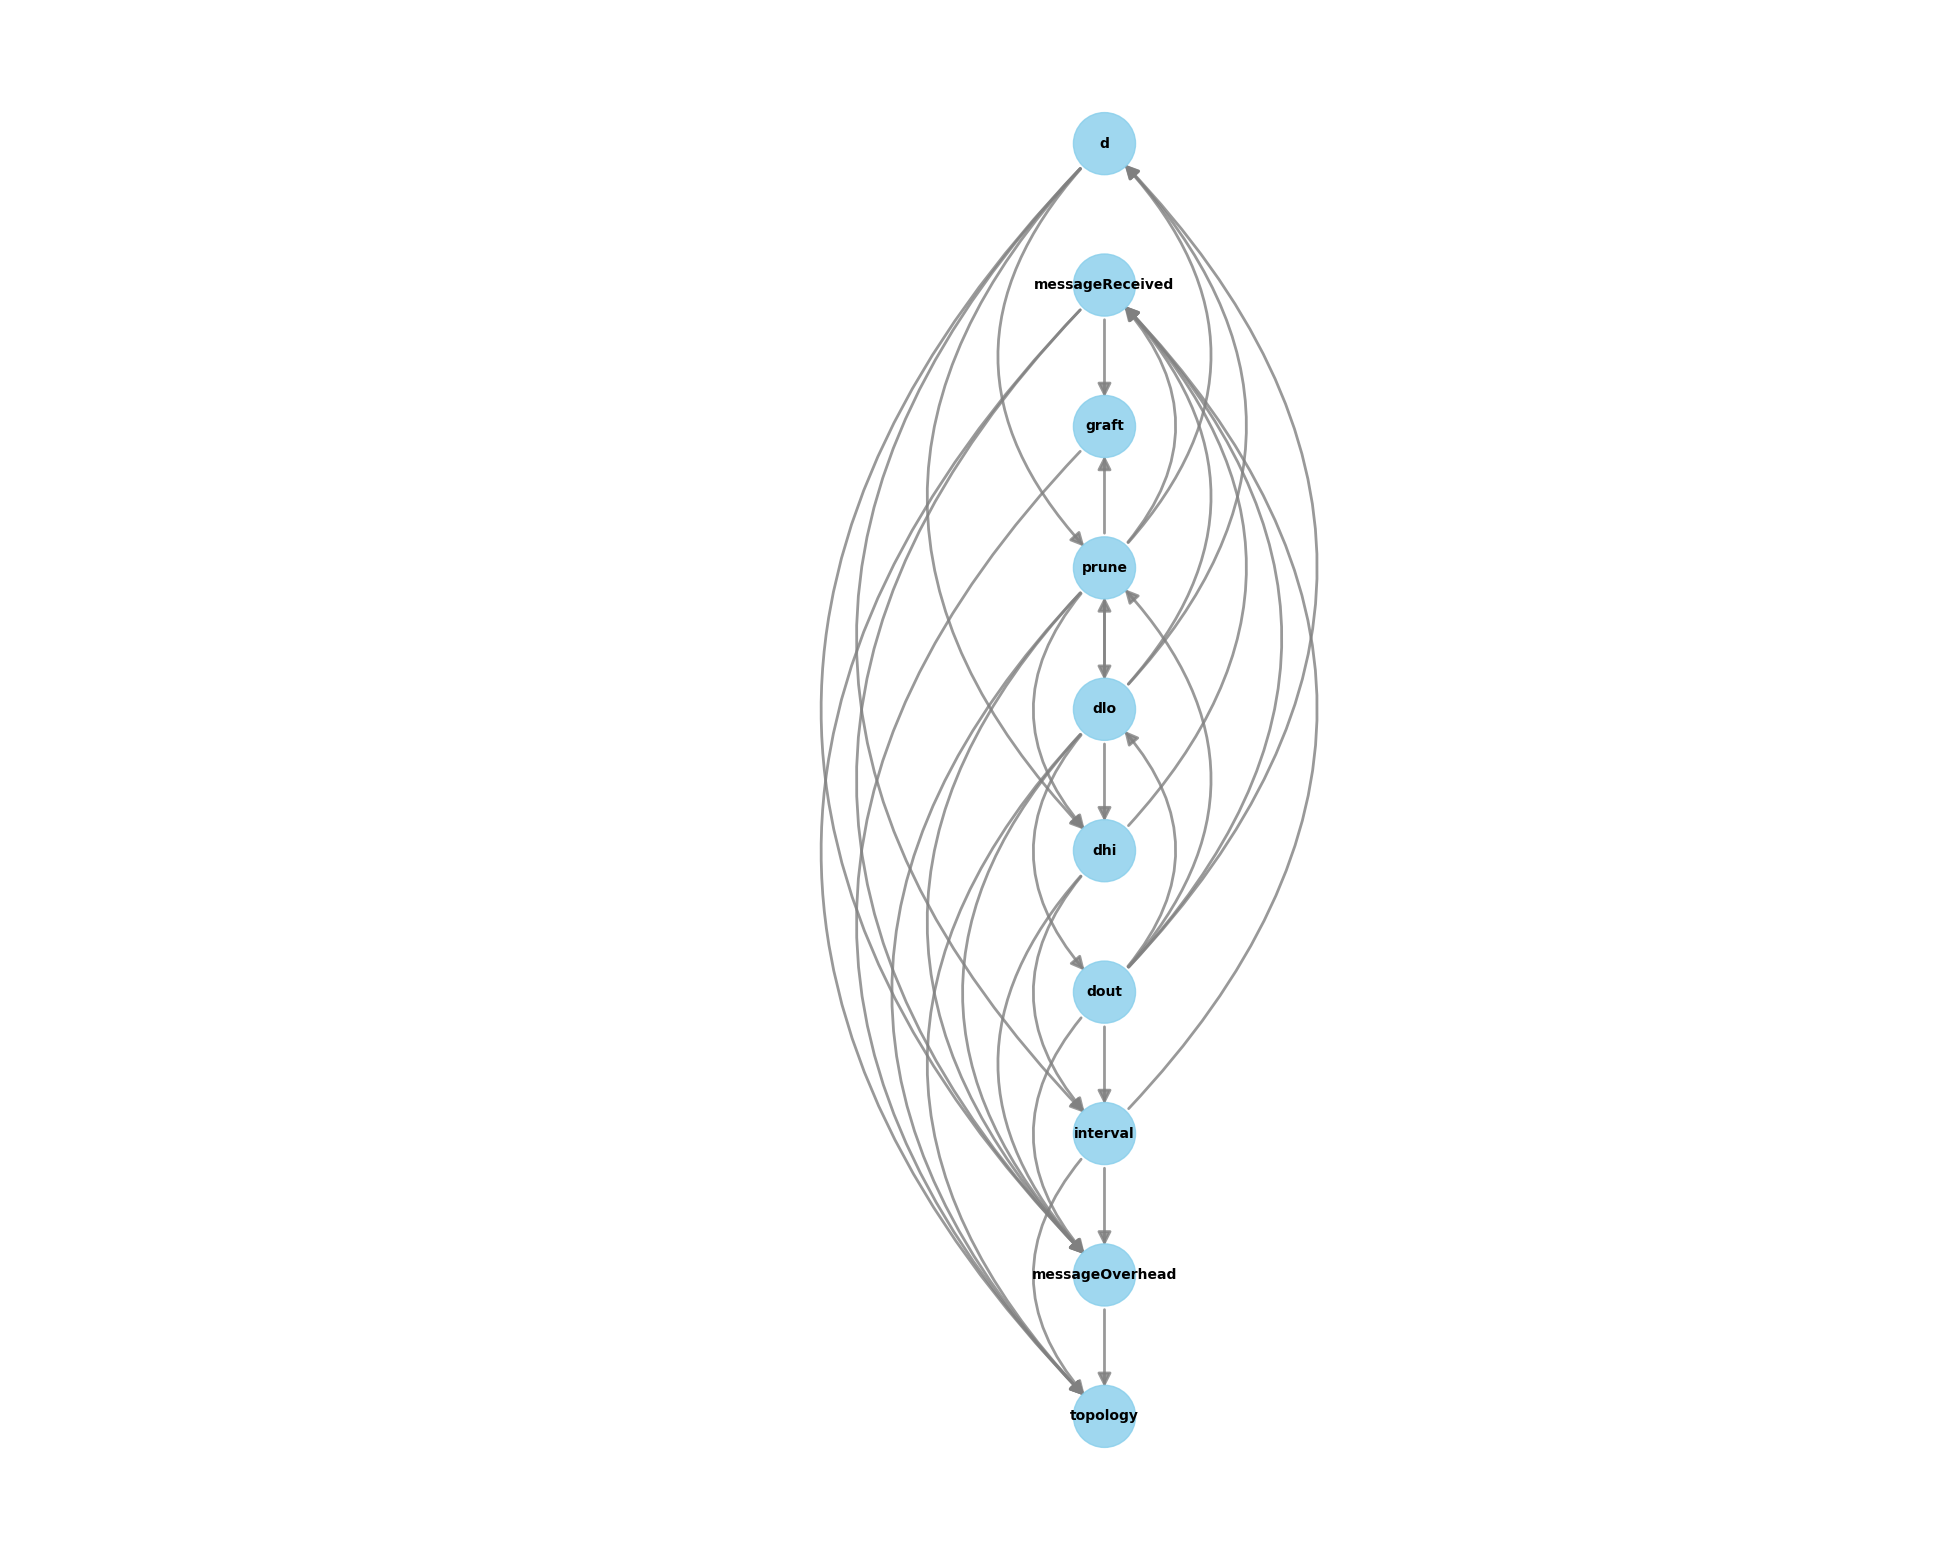

In [38]:
learned_causal_graph = nx.from_numpy_array(ges.causal_matrix, create_using=nx.DiGraph)

mapping = {0:'d',
            1:'messageReceived',
            2:'graft',
            3:'prune',
            4:'dlo',
            5:'dhi',
            6:'dout',
            7:'interval',
            8:'messageOverhead',
            9:'topology'}

# nx.set_node_attributes(learned_causal_graph, labels, "name")
H = nx.relabel_nodes(learned_causal_graph, mapping)

# fig, ax = plt.subplots(figsize=(30,30))

G=gcm.util.plot(H, figure_size=[25, 20])

nx.write_adjlist(H, "ges5s_lotus.adjlist")


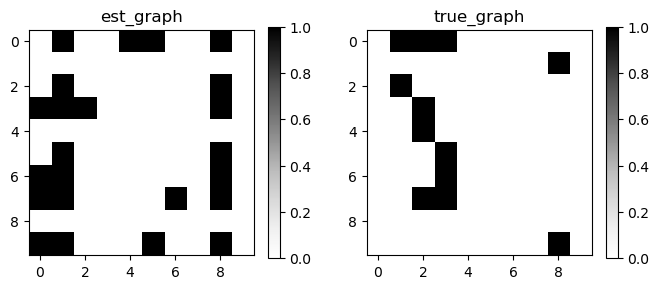

{'fdr': 0.8261, 'tpr': 0.3333, 'fpr': 0.5758, 'shd': 26, 'nnz': 23, 'precision': 0.1739, 'recall': 0.3333, 'F1': 0.2286, 'gscore': 0.0}


In [39]:
g = DirectLiNGAM()
g.learn(X)

# plot est_dag and true_dag
GraphDAG(g.causal_matrix, true_causal_matrix)#, true_dag)

# calculate accuracy
met = MetricsDAG(g.causal_matrix, true_causal_matrix)#, true_dag)
print(met.metrics)

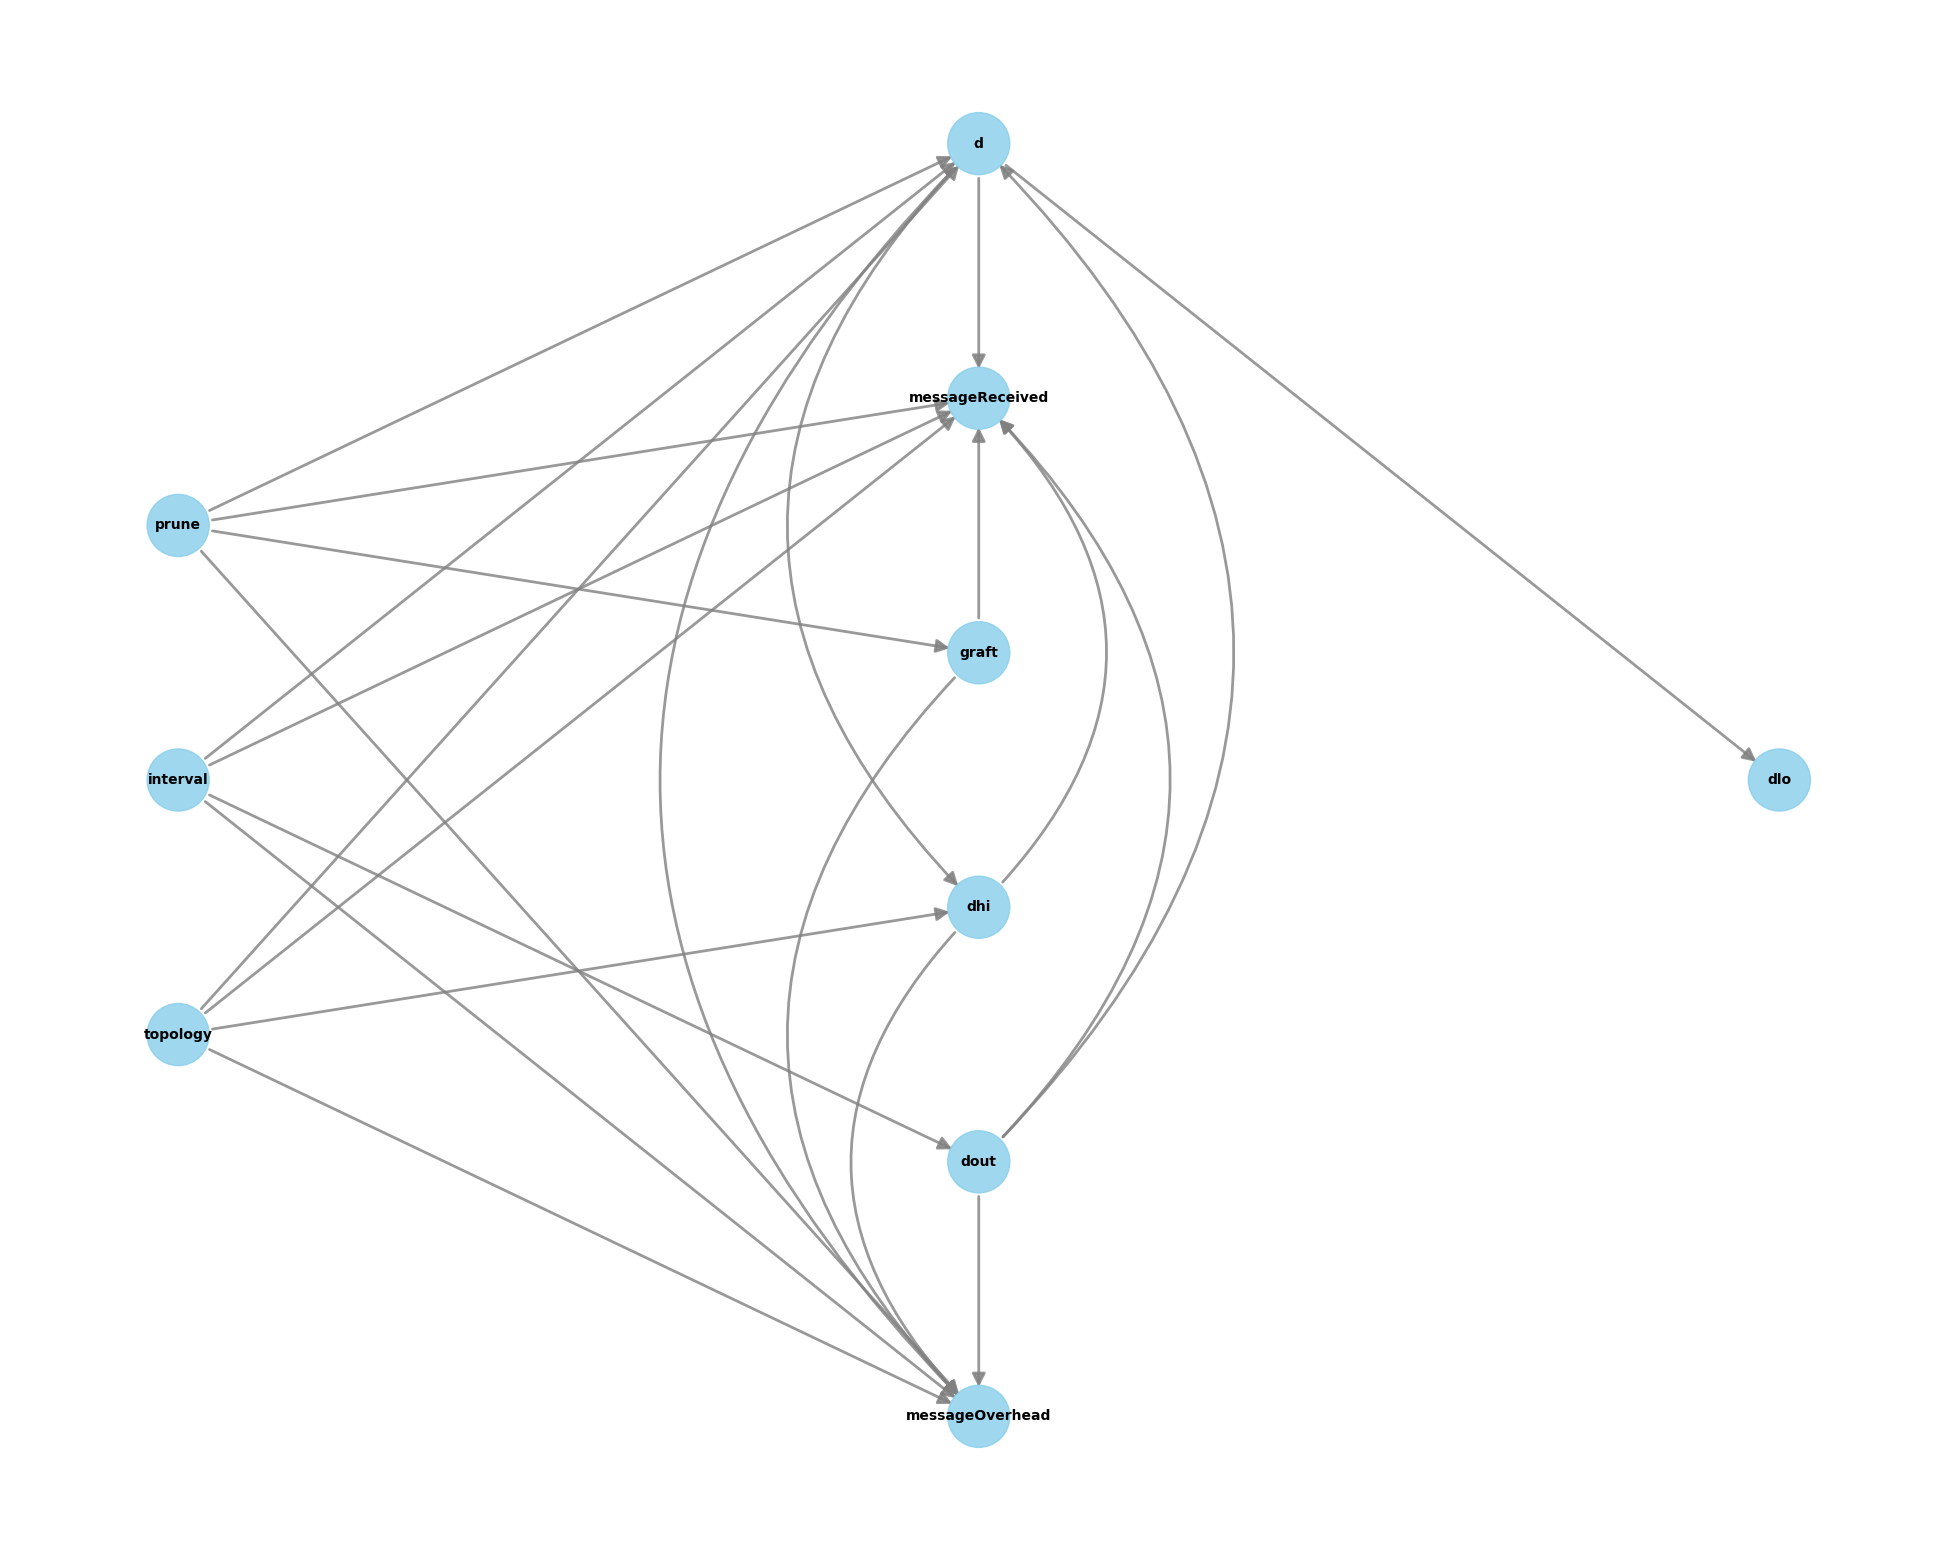

In [40]:
learned_causal_graph = nx.from_numpy_array(g.causal_matrix, create_using=nx.DiGraph)

mapping = {0:'d',
            1:'messageReceived',
            2:'graft',
            3:'prune',
            4:'dlo',
            5:'dhi',
            6:'dout',
            7:'interval',
            8:'messageOverhead',
            9:'topology'}

# nx.set_node_attributes(learned_causal_graph, labels, "name")
H = nx.relabel_nodes(learned_causal_graph, mapping)

# fig, ax = plt.subplots(figsize=(30,30))

G=gcm.util.plot(H, figure_size=[25, 20])

nx.write_adjlist(H, "directLingam5s_lotus.adjlist")


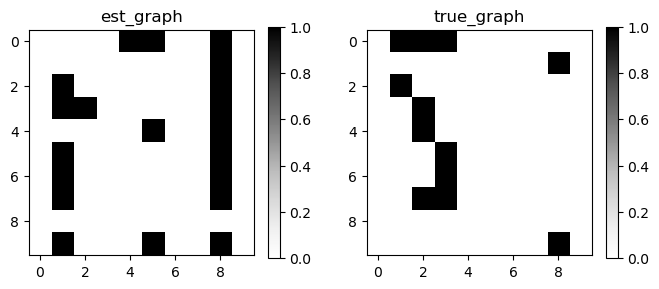

{'fdr': 0.8, 'tpr': 0.3333, 'fpr': 0.4848, 'shd': 24, 'nnz': 20, 'precision': 0.2, 'recall': 0.3333, 'F1': 0.25, 'gscore': 0.0}


In [41]:
g2 = ICALiNGAM()
g2.learn(X)

# plot est_dag and true_dag
GraphDAG(g2.causal_matrix, true_causal_matrix)

# calculate accuracy
met = MetricsDAG(g2.causal_matrix, true_causal_matrix)
print(met.metrics)

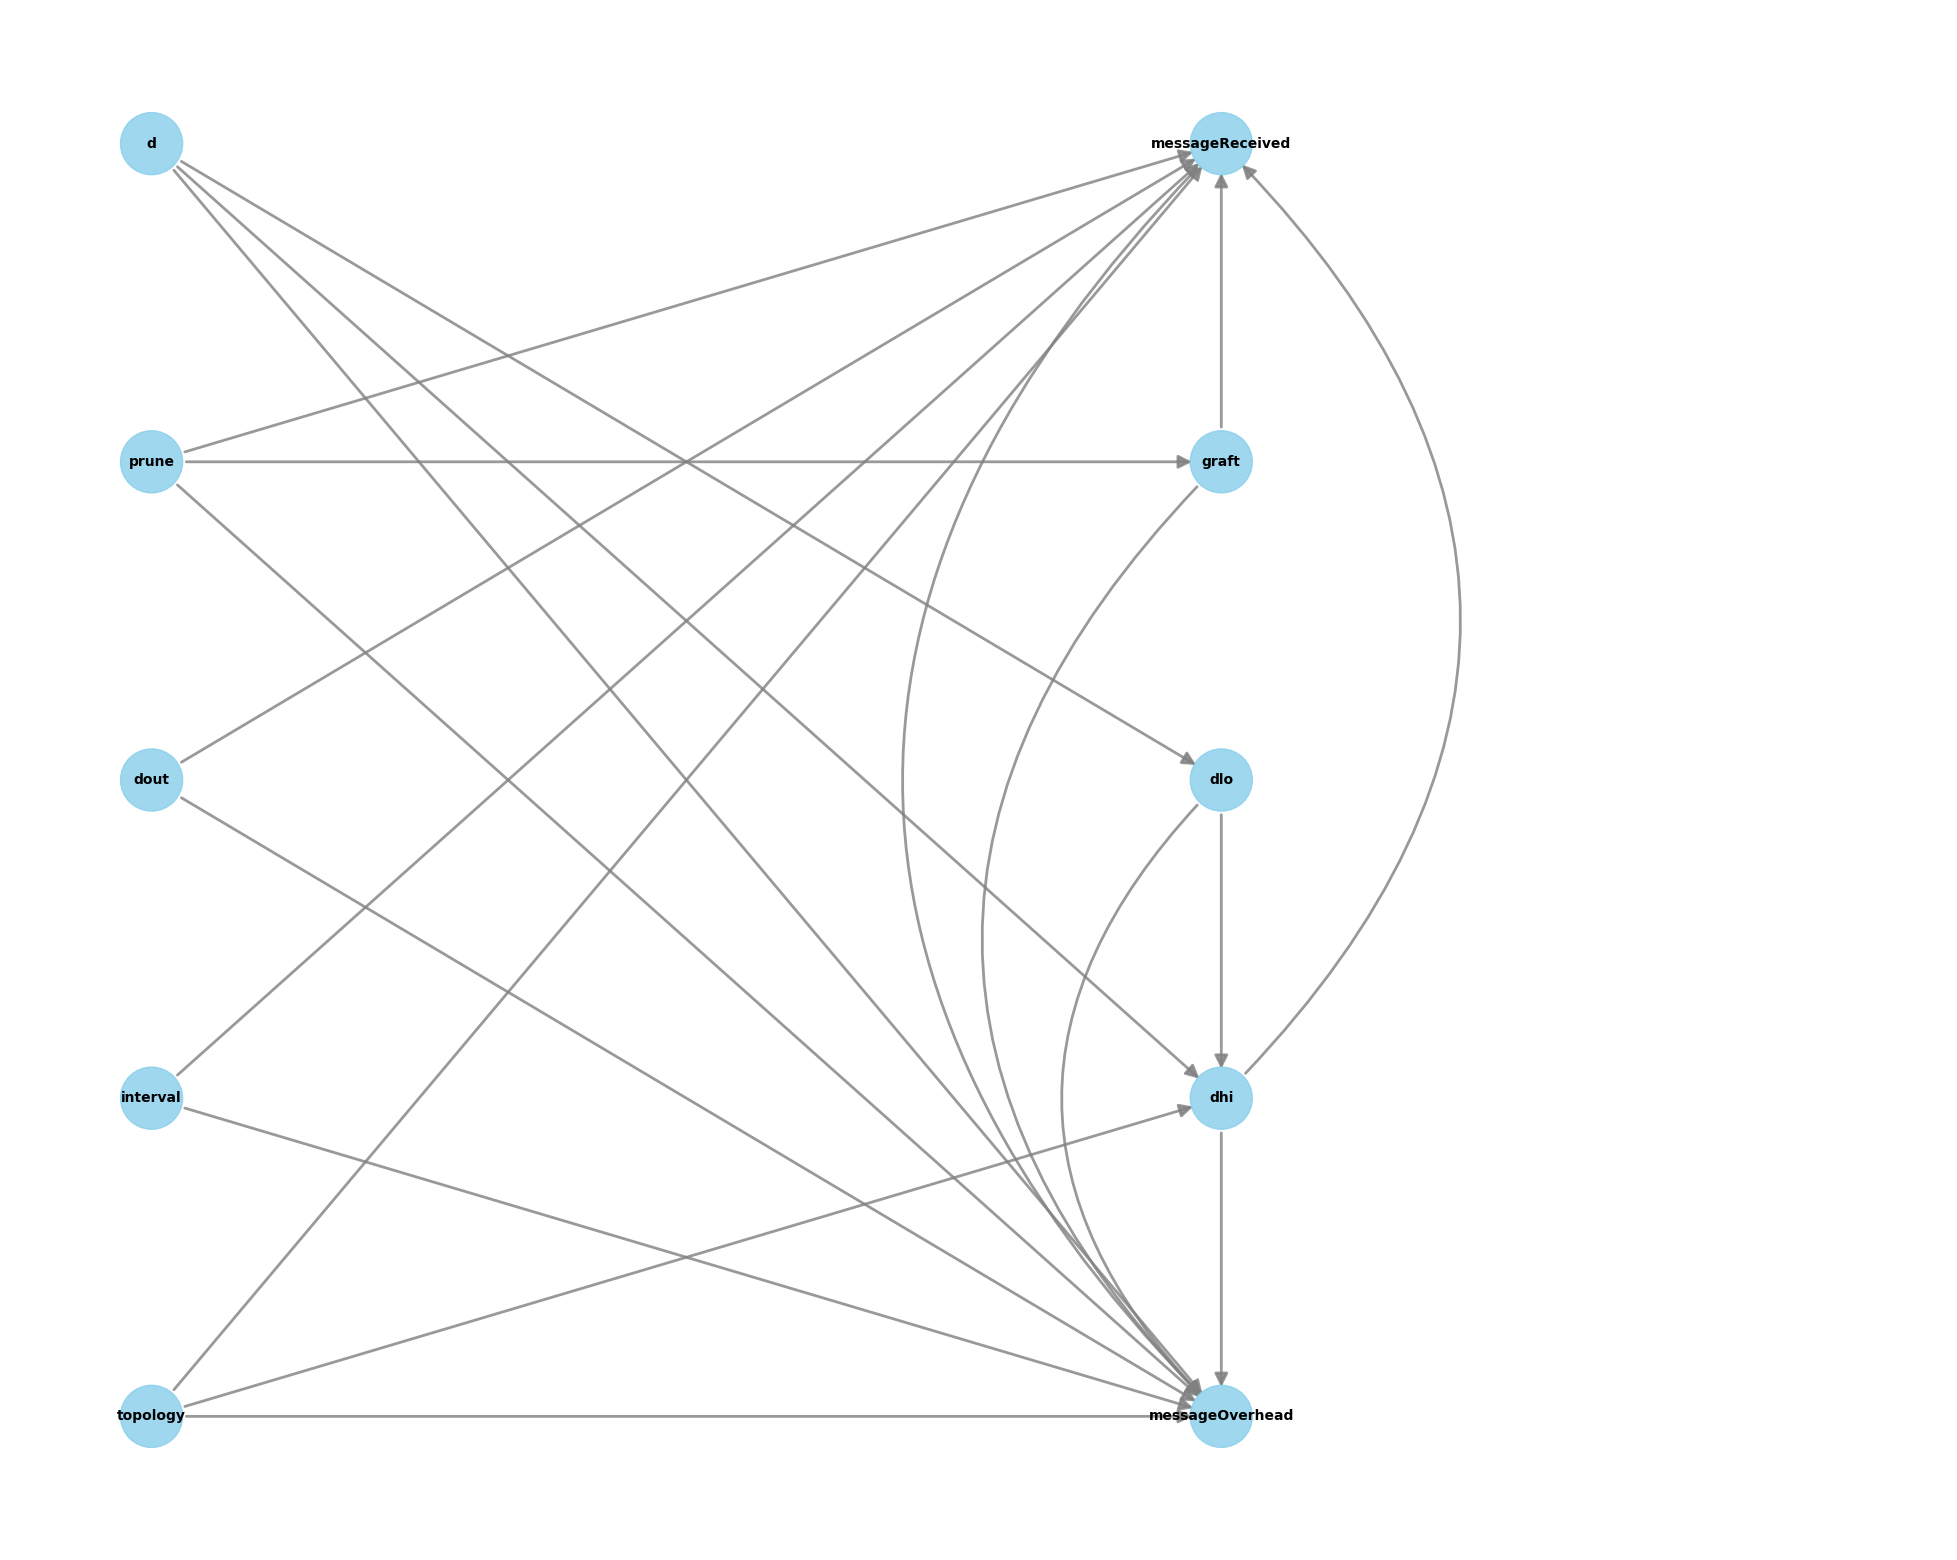

In [42]:
learned_causal_graph = nx.from_numpy_array(g2.causal_matrix, create_using=nx.DiGraph)

mapping = {0:'d',
            1:'messageReceived',
            2:'graft',
            3:'prune',
            4:'dlo',
            5:'dhi',
            6:'dout',
            7:'interval',
            8:'messageOverhead',
            9:'topology'}

# nx.set_node_attributes(learned_causal_graph, labels, "name")
H = nx.relabel_nodes(learned_causal_graph, mapping)

# fig, ax = plt.subplots(figsize=(30,30))

G=gcm.util.plot(H, figure_size=[25, 20])

nx.write_adjlist(H, "ICALingam5s_lotus.adjlist")